In [30]:
import numpy as np
import random
from shapely.geometry import Point, MultiPoint
from scipy.optimize import differential_evolution as scipy_de
from shapely.ops import nearest_points

import voronoi_utils as vu
import solvers

def is_feasible(n, fixed, polygon, A_min, params, solver="custom"):
    if n == 0:
        _, areas = vu.get_voronoi_cells_and_areas(fixed, polygon)
        ok = min(areas) >= A_min
        print(f"[n=0] {'feasible' if ok else 'not feasible'}")
        if ok:
            vu.plot_voronoi(fixed, [], polygon)
        return ok, []

    minx, miny, maxx, maxy = polygon.bounds
    bounds = [(minx, maxx), (miny, maxy)] * n

    def loss(x_flat):
        pts = [(x_flat[i], x_flat[i+1]) for i in range(0, len(x_flat), 2)]
        for xi, yi in pts:
            if not polygon.contains(Point(xi, yi)):
                return 1e6
        _, areas = vu.get_voronoi_cells_and_areas(fixed + pts, polygon)
        return -min(areas)

    if solver == "custom":
        bx, bf = solvers.differential_evolution_custom(loss, bounds, polygon, A_min, params)
    elif solver == "scipy":
        res = scipy_de(loss, bounds,
                       maxiter=params["maxiter"],
                       popsize=params["popsize"],
                       seed=params.get("seed", None),
                       updating="deferred")
        bx, bf = res.x, res.fun
    elif solver == "qpso":
        bx, bf = solvers.qpso_solver(loss, bounds, polygon, A_min, params)
    elif solver == "qpso2":
        bx, bf = solvers.qpso_pairwise_solver(loss, bounds, polygon, A_min, params)
    elif solver == "ga":
        bx, bf = solvers.ga_solver(loss, bounds, polygon, A_min, params)
    elif solver == "spsa":
        bx, bf = solvers.spsa_solver(loss, bounds, polygon, A_min, params)
    else:
        raise ValueError("Unknown solver")

    best_min = -bf
    ok = best_min >= A_min
    print(f"[n={n}] {'feasible' if ok else 'not feasible'} with min_cell_area = {best_min:.4f}")
    if ok:
        added = [(bx[i], bx[i+1]) for i in range(0, len(bx), 2)]
        vu.plot_voronoi(fixed, added, polygon)
        return True, added
    return False, []

def find_max_additional(fixed, polygon, A_min, params, solver="custom"):
    print(f"Minimum area threshold (A_min): {A_min:.4f}")
    ok, _ = is_feasible(0, fixed, polygon, A_min, params, solver)
    if not ok:
        return 0, []

    low, n = 0, 1
    best_added = []
    while True:
        ok, added = is_feasible(n, fixed, polygon, A_min, params, solver)
        if not ok:
            break
        low, best_added = n, added
        n *= 2

    print(f"Starting binary search between n={low} (feasible) and n={n} (infeasible)")
    lo, hi = low, n
    while lo < hi - 1:
        mid = (lo + hi) // 2
        ok, added = is_feasible(mid, fixed, polygon, A_min, params, solver)
        if ok:
            lo, best_added = mid, added
        else:
            hi = mid

    print(f"Result → Max extra points: {lo}")
    return lo, best_added


# seed
 = 3 we have 8 achivealbe
 
 = 30 we have 9

 = 6 we have 8

In [31]:
s = 7
random.seed(s)
np.random.seed(s)

pts = np.random.rand(30, 2)
polygon = MultiPoint([tuple(p) for p in pts]).convex_hull

fixed = []
minx, miny, maxx, maxy = polygon.bounds
while len(fixed) < 5:
    x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
    if polygon.contains(Point(x, y)):
        fixed.append((x, y))

A_min = polygon.area / 15

custom_params = {"maxiter": 100, "popsize": 15, "F": 0.8, "CR": 0.7, "seed": None}
scipy_params  = {"maxiter": 100, "popsize": 15, "seed": None}
qpso_params   = {"maxiter": 100, "popsize": 15, "alpha": 0.75, "seed": None}
ga_params     = {
    "popsize": 50,
    "ngen": 40,
    "cxpb": 0.6,
    "mutpb": 0.3,
    "sigma": 0.1,
    "indpb": 0.1,
    "seed": None
}




=== SPSA Solver ===
Minimum area threshold (A_min): 0.0404
[n=0] feasible
Voronoi cell areas: ['0.175', '0.059', '0.103', '0.0598', '0.209']


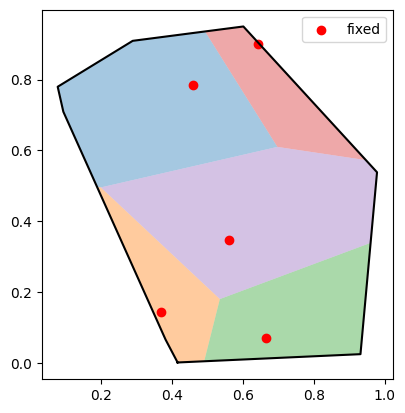

[n=1] feasible with min_cell_area = 0.0420
Voronoi cell areas: ['0.17', '0.059', '0.0876', '0.144', '0.103', '0.042']


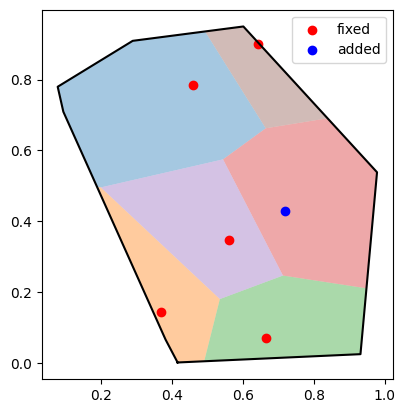

[n=2] feasible with min_cell_area = 0.0428
Voronoi cell areas: ['0.0822', '0.131', '0.0428', '0.0463', '0.127', '0.0597', '0.117']


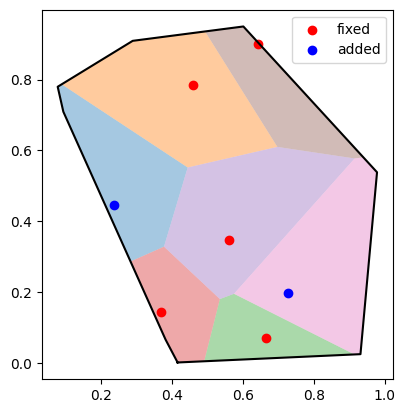

[n=4] feasible with min_cell_area = 0.0404
Voronoi cell areas: ['0.158', '0.0423', '0.0828', '0.0474', '0.0454', '0.0917', '0.0405', '0.0404', '0.0571']


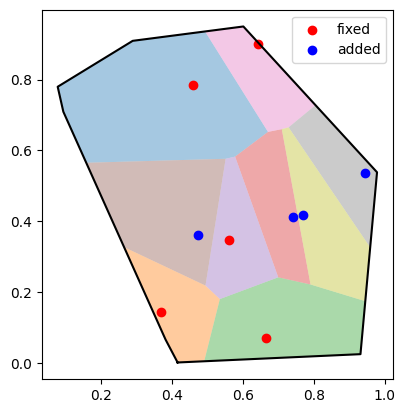

[n=8] feasible with min_cell_area = 0.0404
Voronoi cell areas: ['0.044', '0.0457', '0.0409', '0.0482', '0.0429', '0.0404', '0.0475', '0.0405', '0.0404', '0.0449', '0.0429', '0.0812', '0.046']


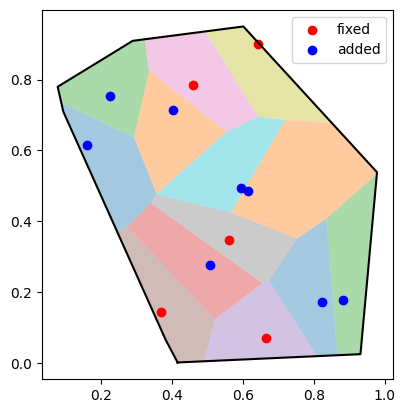

[n=16] not feasible with min_cell_area = 0.0237
Starting binary search between n=8 (feasible) and n=16 (infeasible)
[n=12] not feasible with min_cell_area = 0.0301
[n=10] not feasible with min_cell_area = 0.0338
[n=9] not feasible with min_cell_area = 0.0379
Result → Max extra points: 8


(8,
 [(np.float64(0.5073548497273301), np.float64(0.2759661559366012)),
  (np.float64(0.6126890221093148), np.float64(0.48472589003078553)),
  (np.float64(0.4019671940727388), np.float64(0.7130792878725156)),
  (np.float64(0.5951596620118916), np.float64(0.4949573623867513)),
  (np.float64(0.8831315907598822), np.float64(0.17749141386256181)),
  (np.float64(0.1595061537843068), np.float64(0.6160912859296123)),
  (np.float64(0.22517586462877656), np.float64(0.7528200988861731)),
  (np.float64(0.8239110638076721), np.float64(0.17273584580658055))])

In [32]:
spsa_params   = {"maxiter": 350, "a": 0.1, "c": 0.001,
                    "alpha": 0.5, "gamma": 0.001, "restarts": 50, "seed": None}

print("=== SPSA Solver ===")
find_max_additional(fixed, polygon, A_min, spsa_params, solver="spsa")

=== Custom DE ===
Minimum area threshold (A_min): 0.0404
[n=0] feasible
Voronoi cell areas: ['0.175', '0.059', '0.103', '0.0598', '0.209']


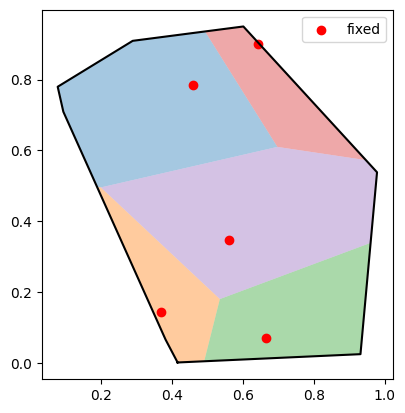

[n=1] feasible with min_cell_area = 0.0590
Voronoi cell areas: ['0.0726', '0.059', '0.103', '0.0592', '0.209', '0.103']


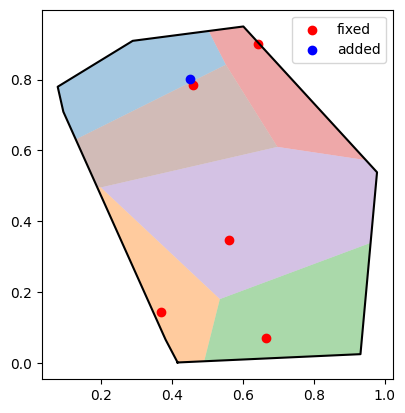

[n=2] feasible with min_cell_area = 0.0500
Voronoi cell areas: ['0.156', '0.05', '0.066', '0.0573', '0.0803', '0.128', '0.0681']


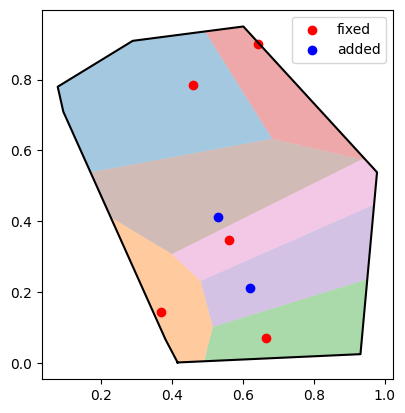

[n=4] feasible with min_cell_area = 0.0453
Voronoi cell areas: ['0.104', '0.0579', '0.066', '0.0453', '0.0941', '0.0476', '0.0535', '0.0782', '0.0594']


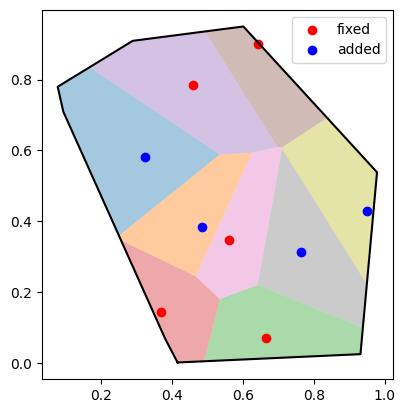

[n=8] not feasible with min_cell_area = 0.0327
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] not feasible with min_cell_area = 0.0376
[n=5] feasible with min_cell_area = 0.0417
Voronoi cell areas: ['0.0527', '0.0417', '0.0452', '0.0712', '0.0523', '0.0421', '0.072', '0.0809', '0.0862', '0.0611']


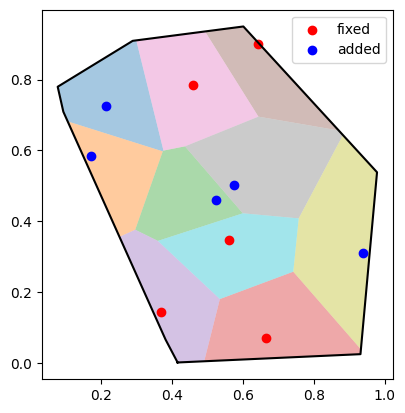

Result → Max extra points: 5


(5,
 [(np.float64(0.2138586353798838), np.float64(0.7253432836798591)),
  (np.float64(0.16926651206794746), np.float64(0.5839541159976955)),
  (np.float64(0.9380333684494295), np.float64(0.3095480831202598)),
  (np.float64(0.5234367957650932), np.float64(0.4594345337659119)),
  (np.float64(0.5735890136057415), np.float64(0.5027871660467268))])

In [33]:
print("=== Custom DE ===")
find_max_additional(fixed, polygon, A_min, custom_params, solver="custom")


=== SciPy DE ===
Minimum area threshold (A_min): 0.0404
[n=0] feasible
Voronoi cell areas: ['0.175', '0.059', '0.103', '0.0598', '0.209']


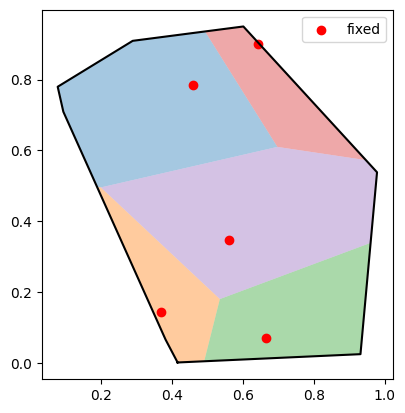

[n=1] feasible with min_cell_area = 0.0590
Voronoi cell areas: ['0.0652', '0.059', '0.103', '0.0596', '0.209', '0.11']


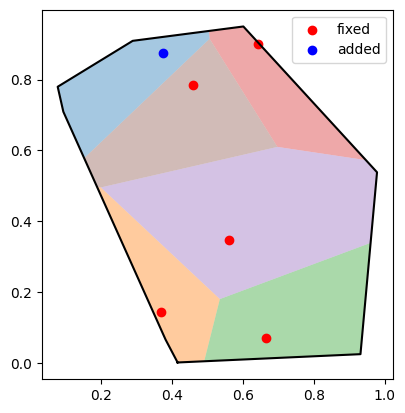

[n=2] feasible with min_cell_area = 0.0590
Voronoi cell areas: ['0.0652', '0.11', '0.059', '0.059', '0.0596', '0.176', '0.0766']


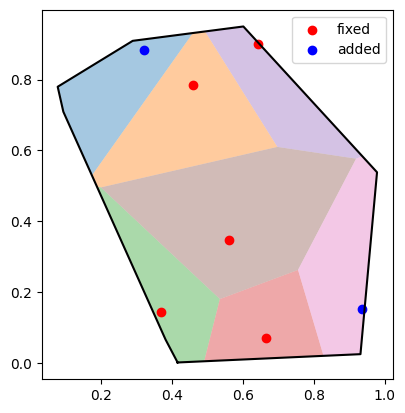

[n=4] feasible with min_cell_area = 0.0581
Voronoi cell areas: ['0.0581', '0.0598', '0.0581', '0.0581', '0.0582', '0.0653', '0.0582', '0.0966', '0.0931']


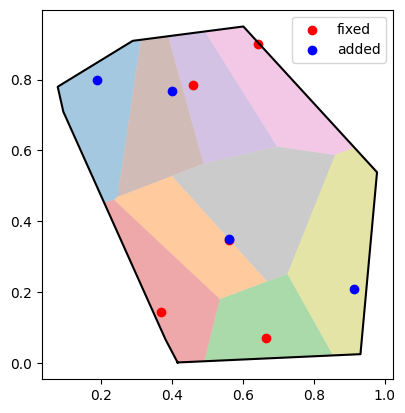

[n=8] not feasible with min_cell_area = 0.0359
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] feasible with min_cell_area = 0.0508
Voronoi cell areas: ['0.057', '0.0508', '0.0514', '0.0584', '0.0508', '0.054', '0.056', '0.0508', '0.0617', '0.0537', '0.061']


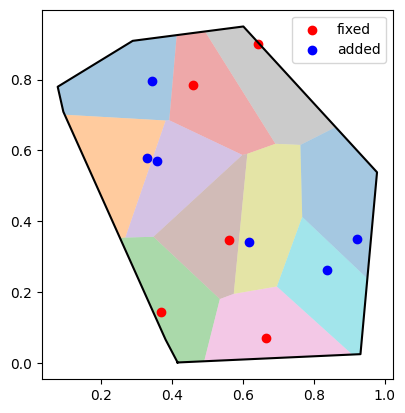

[n=7] feasible with min_cell_area = 0.0473
Voronoi cell areas: ['0.0474', '0.0541', '0.0478', '0.0474', '0.0473', '0.0635', '0.0521', '0.0474', '0.0566', '0.0473', '0.0473', '0.0473']


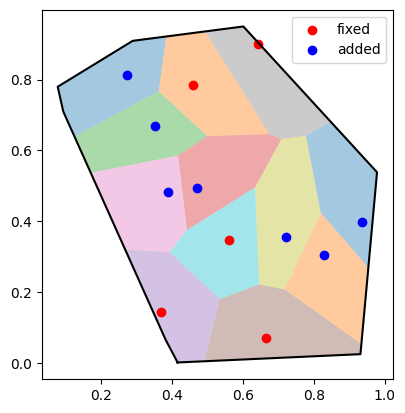

Result → Max extra points: 7


(7,
 [(np.float64(0.38693338340913697), np.float64(0.4836650342702138)),
  (np.float64(0.46847743911985157), np.float64(0.49320074789643725)),
  (np.float64(0.829493635371063), np.float64(0.30379876127248295)),
  (np.float64(0.9367686762961627), np.float64(0.39670512883172215)),
  (np.float64(0.719625588553375), np.float64(0.35519577605875535)),
  (np.float64(0.2729040863210707), np.float64(0.8122681136782259)),
  (np.float64(0.3503888984399083), np.float64(0.668541507827132))])

In [34]:
print("\n=== SciPy DE ===")
find_max_additional(fixed, polygon, A_min, scipy_params, solver="scipy")




=== QPSO (original) ===
Minimum area threshold (A_min): 0.0404
[n=0] feasible
Voronoi cell areas: ['0.175', '0.059', '0.103', '0.0598', '0.209']


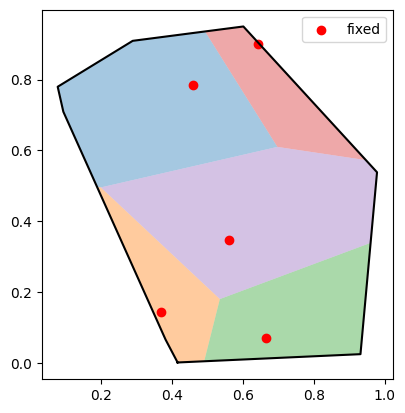

[n=1] feasible with min_cell_area = 0.0576
Voronoi cell areas: ['0.0751', '0.205', '0.103', '0.0576', '0.0598', '0.105']


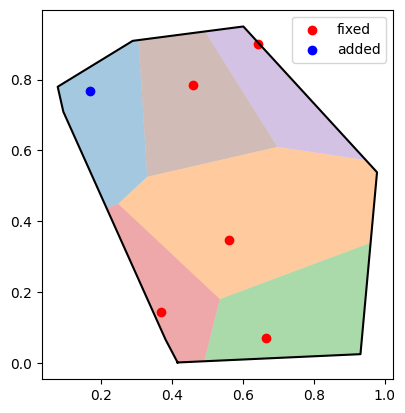

[n=2] feasible with min_cell_area = 0.0534
Voronoi cell areas: ['0.084', '0.101', '0.103', '0.0534', '0.0565', '0.0583', '0.149']


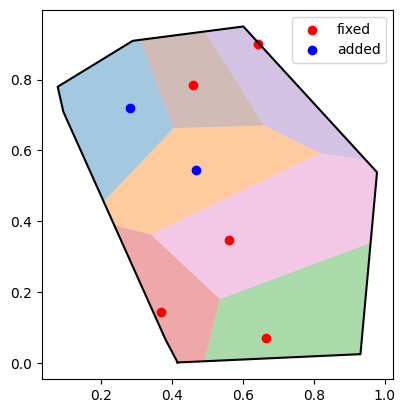

[n=4] feasible with min_cell_area = 0.0438
Voronoi cell areas: ['0.0525', '0.104', '0.0438', '0.0848', '0.0613', '0.0487', '0.0444', '0.103', '0.0621']


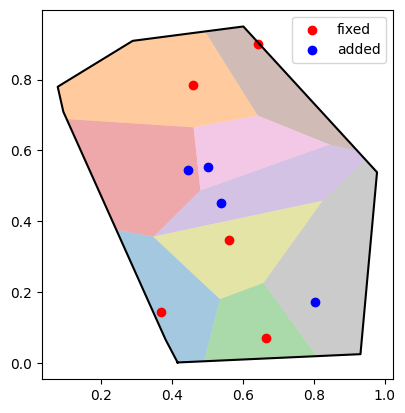

[n=8] not feasible with min_cell_area = 0.0392
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] feasible with min_cell_area = 0.0404
Voronoi cell areas: ['0.0404', '0.0543', '0.0516', '0.045', '0.0435', '0.0409', '0.0666', '0.044', '0.0817', '0.0451', '0.0923']


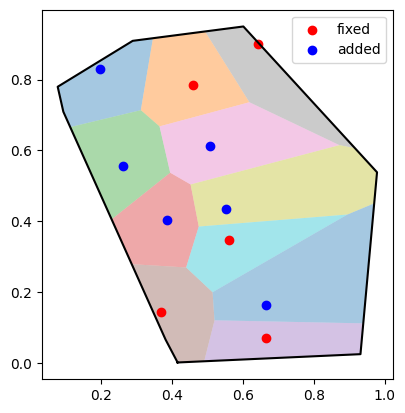

[n=7] not feasible with min_cell_area = 0.0384
Result → Max extra points: 6


(6,
 [(np.float64(0.19490064420647402), np.float64(0.8304045059669739)),
  (np.float64(0.5524746724258007), np.float64(0.4352937873458678)),
  (np.float64(0.3837677665678427), np.float64(0.4025266089100785)),
  (np.float64(0.5053300645925652), np.float64(0.6137931438922086)),
  (np.float64(0.665180141154993), np.float64(0.16493470361091703)),
  (np.float64(0.260344916373793), np.float64(0.5573287604763013))])

In [35]:
print("\n=== QPSO (original) ===")
find_max_additional(fixed, polygon, A_min, qpso_params, solver="qpso")




=== QPSO (pairwise) ===
Minimum area threshold (A_min): 0.0404
[n=0] feasible
Voronoi cell areas: ['0.175', '0.059', '0.103', '0.0598', '0.209']


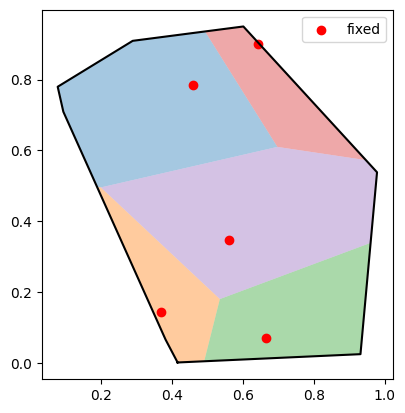

[n=1] feasible with min_cell_area = 0.0586
Voronoi cell areas: ['0.0741', '0.208', '0.103', '0.0586', '0.0598', '0.102']


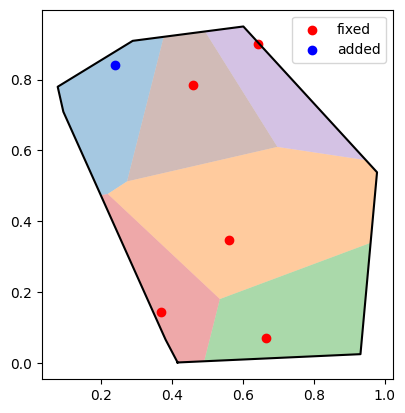

[n=2] feasible with min_cell_area = 0.0509
Voronoi cell areas: ['0.146', '0.0526', '0.0542', '0.0509', '0.0749', '0.149', '0.0777']


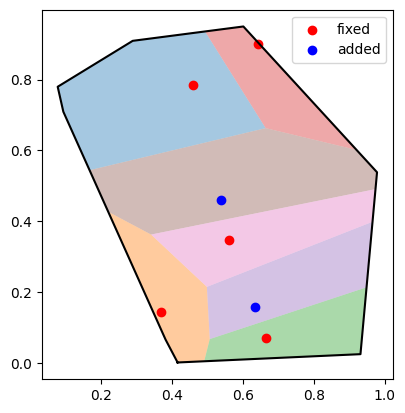

[n=4] feasible with min_cell_area = 0.0404
Voronoi cell areas: ['0.0459', '0.0506', '0.0965', '0.0694', '0.0801', '0.0739', '0.0722', '0.0765', '0.0404']


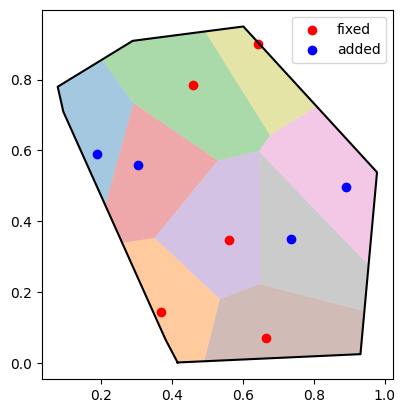

[n=8] not feasible with min_cell_area = 0.0378
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] feasible with min_cell_area = 0.0407
Voronoi cell areas: ['0.0565', '0.0456', '0.0841', '0.0451', '0.0444', '0.0428', '0.0424', '0.0489', '0.0407', '0.0474', '0.108']


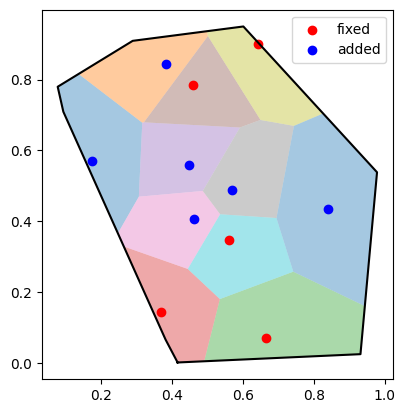

[n=7] feasible with min_cell_area = 0.0406
Voronoi cell areas: ['0.0467', '0.0414', '0.0453', '0.068', '0.0417', '0.073', '0.0507', '0.0406', '0.0462', '0.0653', '0.0422', '0.0444']


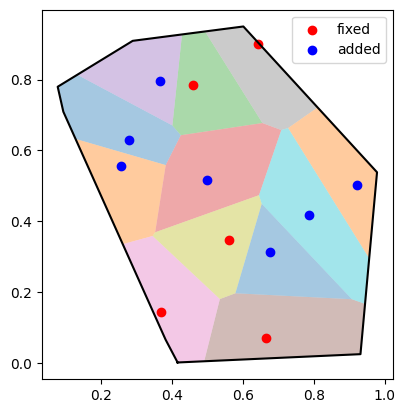

Result → Max extra points: 7


(7,
 [(np.float64(0.920598391572732), np.float64(0.5021258487018355)),
  (np.float64(0.4992768740822597), np.float64(0.5167541432681027)),
  (np.float64(0.2776068238459352), np.float64(0.6288367733368936)),
  (np.float64(0.6757312158283377), np.float64(0.3141634876165674)),
  (np.float64(0.36658111923553705), np.float64(0.7956661890958598)),
  (np.float64(0.7860411943246541), np.float64(0.41845403787966856)),
  (np.float64(0.2562066624408669), np.float64(0.5550002672176109))])

In [36]:
print("\n=== QPSO (pairwise) ===")
find_max_additional(fixed, polygon, A_min, qpso_params, solver="qpso2")




=== GA Solver ===
Minimum area threshold (A_min): 0.0404
[n=0] feasible
Voronoi cell areas: ['0.175', '0.059', '0.103', '0.0598', '0.209']


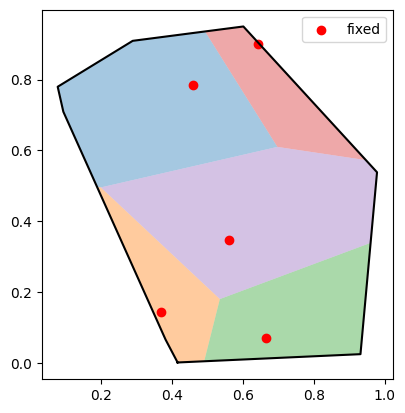

[n=1] feasible with min_cell_area = 0.0589
Voronoi cell areas: ['0.175', '0.0589', '0.0601', '0.059', '0.131', '0.122']


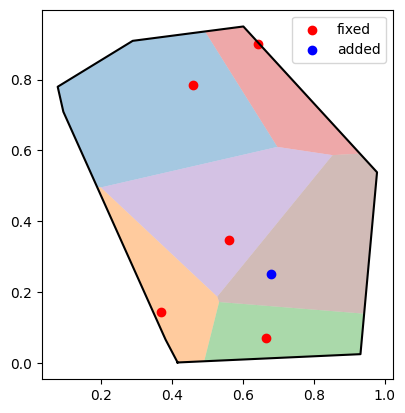

[n=2] feasible with min_cell_area = 0.0526
Voronoi cell areas: ['0.175', '0.059', '0.0628', '0.0526', '0.121', '0.0681', '0.0665']


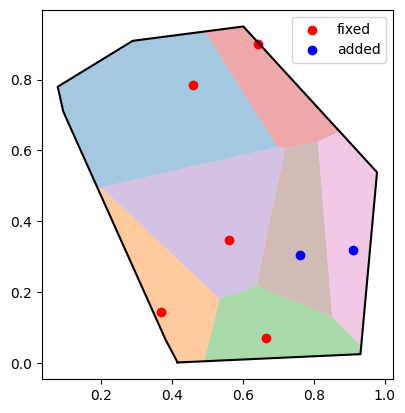

[n=4] feasible with min_cell_area = 0.0444
Voronoi cell areas: ['0.0951', '0.06', '0.0472', '0.0541', '0.0578', '0.102', '0.0444', '0.0593', '0.0853']


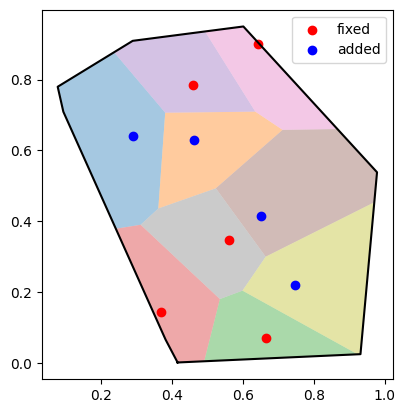

[n=8] not feasible with min_cell_area = 0.0401
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] feasible with min_cell_area = 0.0413
Voronoi cell areas: ['0.051', '0.0482', '0.0466', '0.0443', '0.0518', '0.0432', '0.051', '0.0888', '0.0413', '0.0908', '0.0485']


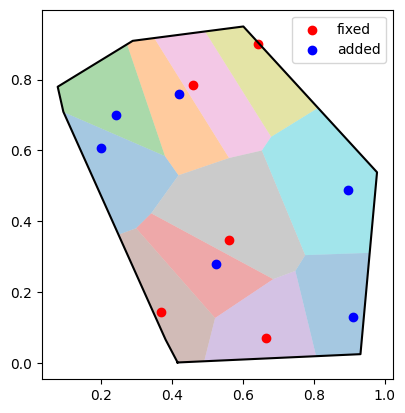

[n=7] feasible with min_cell_area = 0.0405
Voronoi cell areas: ['0.0548', '0.0595', '0.0431', '0.0408', '0.0487', '0.0405', '0.0438', '0.0555', '0.0657', '0.0594', '0.0507', '0.043']


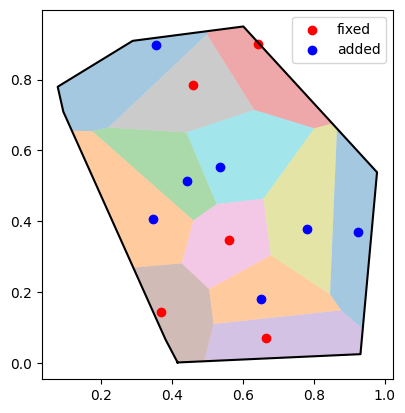

Result → Max extra points: 7


(7,
 [(0.5357457263068789, 0.5543859800420239),
  (0.34585914335398704, 0.4058979783690072),
  (0.9241961854058156, 0.37107885976169547),
  (0.7814589381347375, 0.3770449964984894),
  (0.3541401824238297, 0.8971414236188626),
  (0.6514516988104421, 0.18053795404306416),
  (0.44199587038608096, 0.5147964925623634)])

In [37]:
print("\n=== GA Solver ===")
find_max_additional(fixed, polygon, A_min, ga_params, solver="ga")

